
* With the current setup
    * Get the yearly mean for our rough estimate

    * Get the weighted areas, to get energy per grid box




* Can we satisfy the instantaneus demand?
    * Get the instantaneus max demand in a year (Najme)

* Where to put the solar panels?
   * Which are the areas of higher contribution (Selma's cool algorithm)
       * Use top 30 boxes for the local maxima ie, 30 boxes with highest pvpot (mean pvpot or sum pvpot)
   * What makes a place a good place to put solar panels? (Najme)
       *  Radiation, temperature and wind are already accounted in pvpot
       *  ?
       *  Are mountains a good place?
       *  Populated areas?
       *  Beach front
       *  Natural reserves (parks)
       *  Ocean or sea ? can we put them in the mediterranian

* Problem for the future:
    * Max pvpot is at mid day, max consumption is in the evenening
       * What is the maximum difference?
       * How much energy should be stored or commerced(import export)?

In [6]:
%load_ext autoreload
%autoreload
import tools as tools
import core as core

In [53]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [57]:
# Open dataset and filter for europe
# range=> [) is open on the right side so +1 to remember
ds = tools.open_dataset(months=range(1,2+1))
ds_eu = tools.filter_europe_box(ds)

# Filter for Iran
# ds_eu = ds.sel(latitude=slice(40, 24)).sel(longitude=slice(40, 62))

In [20]:
ds_eu

<xarray.Dataset> Size: 405MB
Dimensions:     (valid_time: 744, latitude: 141, longitude: 161)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-01-01 ... 2000-01-31T23:...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 12kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

Lets do a rough estimate with the area of europe

In [58]:
# Lets do a rough estimate calculating the overall mean
pvpot_pre = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean(dim=("valid_time","latitude","longitude"))

In [59]:
# Do the proper computation
pvpot = tools.dask_compute(pvpot_pre, workers=5, threads=2)

<Client: 'tcp://127.0.0.1:45445' processes=5 threads=10, memory=753.83 GiB>
Execution time: 7.85476 seconds


In [60]:
tools.print_pvpot_stats(pvpot)

Calculated pvpot:
    Shape: (2,)
    Months: 2
    Min: 0.0470782108604908
    Mean: 0.062469616532325745
    Max: 0.07786102592945099
    Std: 0.015391407534480095
    


AttributeError: 'DataArray' object has no attribute 'longitude'

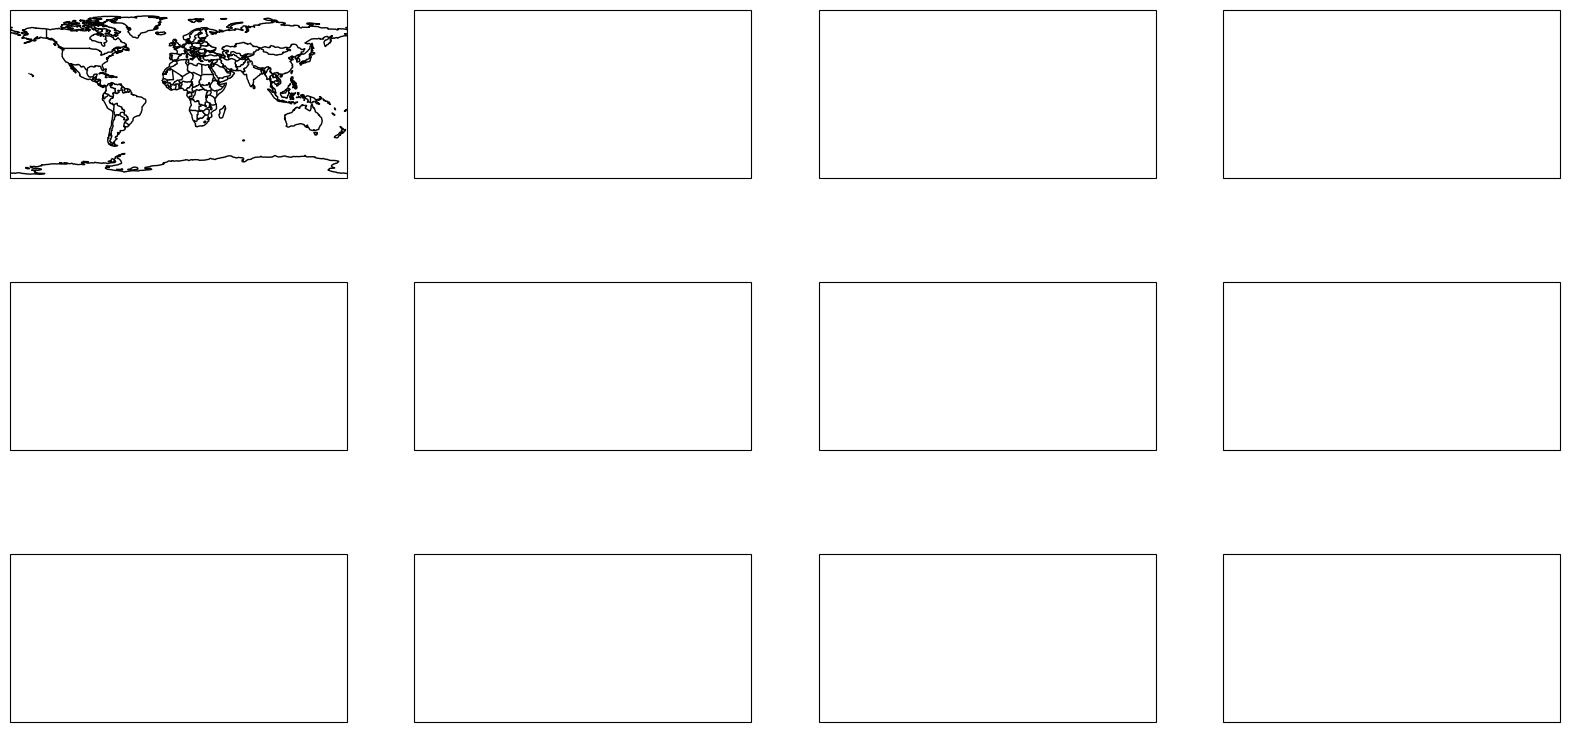

In [61]:
print(f"Each square meter can produce a max of {pvpot.values*237} Watts in January")

Each square meter can produce a max of [11.157536 18.453064] Watts in January


In [68]:
import pint
from pint import UnitRegistry
ureg = UnitRegistry()

# Doing a naive calculation of europe

#AREA:
area_europe = 10.53e6 * (ureg.kilometer * ureg.kilometer)
# '#' compact '~' short 'P' Pretty
print(f"Area Europe: {area_europe:#P}")

# Panel rate for panels ---
panel_rated_ouput = 237 * ureg.watt / (ureg.meter * ureg.meter)
print(f"Panel Rated Output: {panel_rated_ouput:#~P}")

europe_max_solar_energy = np.mean(pvpot.values) * panel_rated_ouput * area_europe
print(f"Max solar energy production europe: {europe_max_solar_energy:#~P.2f}")


europe_max_solar_energy_month = europe_max_solar_energy * (720 * ureg.hour)
print(f"Max solar energy production europe month Wh: {europe_max_solar_energy_month:#~P.2f}")
print(f"Max solar energy production europe month J: {europe_max_solar_energy_month.to('joule'):#P.2f}")


Area Europe: 10.53 megameter²
Panel Rated Output: 237.0 W/m²
Max solar energy production europe: 155.90 TW
Max solar energy production europe month Wh: 112.25 h·PW
Max solar energy production europe month J: 404.09 exajoule


In [69]:
# https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_e__custom_13932565/default/table?lang=en
europe_electricity_consumption = 2824313.722 * 10e9 * ureg.Wh
print(f"{europe_electricity_consumption.to('gigawatthour'):_}")
print(f"{europe_electricity_consumption.to('gigawatthour'):#~P}")

28_243_137.220000003 gigawatt_hour
28.24313722 PWh


In [70]:
# Consumption 
europe_electricity_consumption / europe_max_solar_energy_month 

<Quantity(251614.047, 'watt_hour * meter ** 2 / watt / kilometer ** 2 / hour')>

In [51]:
# 84 PW H europe max January over 28 PW H europe year consumption
84.59/28.2

2.9996453900709223

## Better calculation with More precise area

In [74]:
pvpot_pre = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean(dim=("valid_time"))

In [75]:
pvpot = tools.dask_compute(pvpot_pre, workers=5, threads=2)

<Client: 'tcp://127.0.0.1:45663' processes=5 threads=10, memory=753.83 GiB>
Execution time: 8.01899 seconds


In [76]:
tools.print_pvpot_stats(pvpot)

Calculated pvpot:
    Shape: (2, 141, 161)
    Months: 2
    Min: 0.00024747772840783
    Mean: 0.062469638884067535
    Max: 0.19252273440361023
    Std: 0.0459207259118557
    


Text(0.5, 0.98, 'MegaWatts Hour per month per m^2')

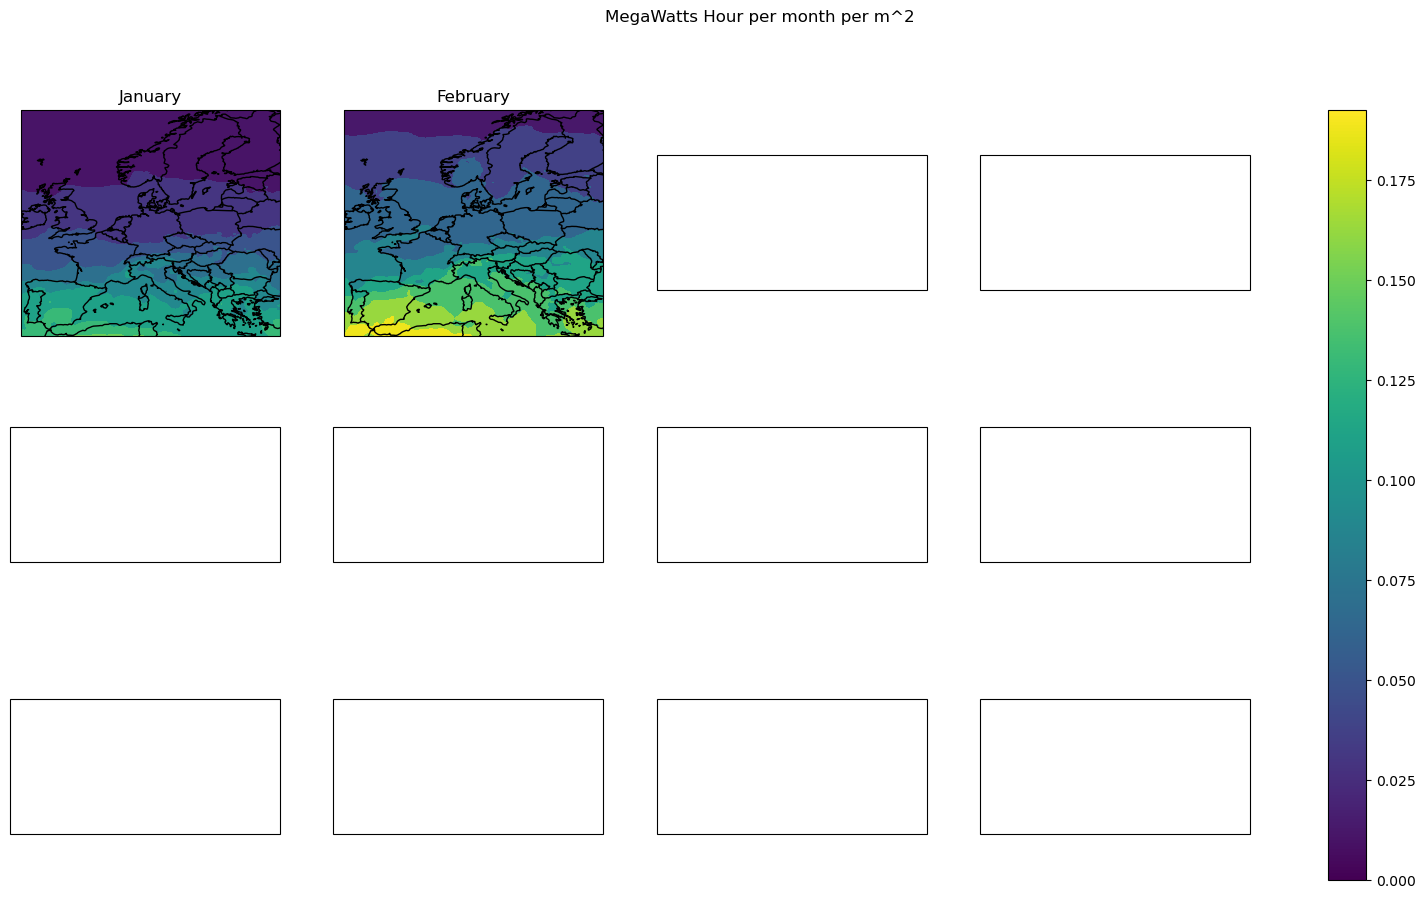

In [77]:
fg, ax = tools.plot_pvpot_per_month(pvpot, 0, pvpot.max())
fg.suptitle("MegaWatts Hour per month per m^2")

In [79]:
import math
def calculate_cell_area(lat1, lat2, lon1, lon2, radius=6371):
    # Convert degrees to radians
    lat1, lat2, lon1, lon2 = map(math.radians, [lat1, lat2, lon1, lon2])
    
    # Calculate the area
    area = radius**2 * abs(math.sin(lat2) - math.sin(lat1)) * abs(lon2 - lon1)
    return area

# Example: Calculate area of a cell
# lat1, lat2 = 3, 3.25  # Latitude bounds
# lon1, lon2 = 5, 5.25  # Longitude bounds
# area = calculate_cell_area(lat1, lat2, lon1, lon2)
# print(f"Area of the cell: {area:.2f} km²")

In [80]:
def grid_cell_area(ds, radius=6371):
    """
    Berechnet die Fläche jeder Gitterzelle basierend auf lat/lon.
    
    Parameters:
        ds (xarray.Dataset): Dataset mit lat/lon-Dimensionen.
        radius (float): Erdradius in Kilometern (Standard: 6371 km).
        
    Returns:
        xarray.DataArray: Flächenwerte für alle Zellen.
    """
    # Sekunden pro Stunde (falls später benötigt)
    sechour = 3600 

    # Extrahiere die Koordinaten für Latitude und Longitude
    lat = ds['latitude'].values
    lon = ds['longitude'].values

    # Berechnung der Bounds (Lat/Lon-Zellenränder)
    lat_bounds = np.concatenate(([lat[0] - (lat[1] - lat[0]) / 2], 
                                  lat[:-1] + np.diff(lat) / 2, 
                                  [lat[-1] + (lat[-1] - lat[-2]) / 2]))
    lon_bounds = np.concatenate(([lon[0] - (lon[1] - lon[0]) / 2], 
                                  lon[:-1] + np.diff(lon) / 2, 
                                  [lon[-1] + (lon[-1] - lon[-2]) / 2]))

    # Flächendifferenzen in Radians
    dlat = np.abs(np.diff(np.sin(np.radians(lat_bounds))))
    dlon = np.abs(np.diff(lon_bounds)) * np.pi / 180

    # Gitter für dlat und dlon erstellen
    dlat_grid, dlon_grid = np.meshgrid(dlat, dlon, indexing="ij")

    # Flächenberechnung für jede Gitterzelle
    cell_areas = radius**2 * dlat_grid * dlon_grid

    # Rückgabe als DataArray
    area_da = xr.DataArray(
        cell_areas,
        coords={"latitude": lat, "longitude": lon},
        dims=["latitude", "longitude"],
        name="cell_area"
    )
    return area_da


In [81]:
ds_eu['cell_area'] = grid_cell_area(ds_eu)
ds_eu['pv_pot'] = pvpot

In [82]:
ds_eu

<xarray.Dataset> Size: 785MB
Dimensions:     (valid_time: 1440, latitude: 141, longitude: 161, month: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 12kB 2000-01-01 ... 2000-02-29T23...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 23kB dask.array<chunksize=(744,), meta=np.ndarray>
  * month       (month) int64 16B 1 2
Data variables:
    t2m         (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    cell_area   (latitude, longitude) float64 182kB 264.3 264.3 ... 633.0 633.0
    pv_pot      (month, latitude, longitude) float32 182kB 0.0003122 ... 0.1669
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [86]:
# Panel rate for panels ---
panel_rated_ouput_per_m2 = 237 # Watts 

ds_eu["energy_potential_per_m2"] = ds_eu["pv_pot"] * panel_rated_ouput_per_m2

ds_eu["energy_potential_per_cell"] = ds_eu["energy_potential_per_m2"] * ds_eu["cell_area"] * 1e6 # Since cell area is in km^2

In [87]:
ds_eu

<xarray.Dataset> Size: 785MB
Dimensions:                    (valid_time: 1440, latitude: 141,
                                longitude: 161, month: 2)
Coordinates:
    number                     int64 8B 0
  * valid_time                 (valid_time) datetime64[ns] 12kB 2000-01-01 .....
  * latitude                   (latitude) float64 1kB 70.0 69.75 ... 35.25 35.0
  * longitude                  (longitude) float64 1kB -10.0 -9.75 ... 30.0
    expver                     (valid_time) <U4 23kB dask.array<chunksize=(744,), meta=np.ndarray>
  * month                      (month) int64 16B 1 2
Data variables:
    t2m                        (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrd                       (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrdc                      (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    u10                        (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    v10                        (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    wspd                       (valid_time, latitude, longitude) float32 131MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    cell_area                  (latitude, longitude) float64 182kB 264.3 ... ...
    pv_pot                     (month, latitude, longitude) float32 182kB 0.0...
    energy_potential_per_m2    (month, latitude, longitude) float32 182kB 0.0...
    energy_potential_per_cell  (month, latitude, longitude) float64 363kB 1.9...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [30]:
ds_eu["cell_area"]

<xarray.DataArray 'cell_area' (latitude: 141, longitude: 161)> Size: 182kB
array([[264.30251932, 264.30251932, 264.30251932, ..., 264.30251932,
        264.30251932, 264.30251932],
       [267.46848672, 267.46848672, 267.46848672, ..., 267.46848672,
        267.46848672, 267.46848672],
       [270.62936191, 270.62936191, 270.62936191, ..., 270.62936191,
        270.62936191, 270.62936191],
       ...,
       [629.12312831, 629.12312831, 629.12312831, ..., 629.12312831,
        629.12312831, 629.12312831],
       [631.07517092, 631.07517092, 631.07517092, ..., 631.07517092,
        631.07517092, 631.07517092],
       [633.01519876, 633.01519876, 633.01519876, ..., 633.01519876,
        633.01519876, 633.01519876]])
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0

In [100]:
potential_month = (ds_eu["energy_potential_per_cell"] * 3600 * 24 * 30).sum(axis=(1,2))

In [112]:
potential_month/1e18

<xarray.DataArray 'energy_potential_per_cell' (month: 2)> Size: 16B
array([361.09572289, 568.94225347])
Coordinates:
    number   int64 8B 0
  * month    (month) int64 16B 1 2

In [102]:
print(f"Max solar energy production europe month Wh: {europe_max_solar_energy_month:#~P.2f}")
print(f"Max solar energy production europe month J: {europe_max_solar_energy_month.to('joule'):#P.2f}")

Max solar energy production europe month Wh: 112.25 h·PW
Max solar energy production europe month J: 404.09 exajoule
